In [1]:
# module
import os
import matplotlib.pylab as pl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import datetime
import cv2
import numpy as np
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import dataset_invariance
import index_qualitative
from torch.autograd import Variable
import csv
import time
import tqdm
import torch.nn.functional as F

# Scene colormap 
colors = [(0, 0, 0), (0.87, 0.87, 0.87), (0.54, 0.54, 0.54), (0.49, 0.33, 0.16), (0.29, 0.57, 0.25)]
cmap_name = 'scene_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=5)

In [3]:
ls pretrained_models/M

 MANTRA/                                'model_epoch1492019-11-19 10:41:43'
'model2019-11-08 11:30:41_it4_kernel3'   model_IRM_epoch_449
 model_AE/                               model_MANTRA
 model_controller/                       model_MANTRA_cvpr
 model_decoder_FT/                       model_memory_single.py


In [ ]:
# function
def draw_track(past, future, pred=None, video_id='', vec_id='', index_tracklet=0):

    fig = plt.figure()
    plt.plot(past[:, 0], past[:, 1], c='blue', linewidth=1, marker='o', markersize=1)
    plt.plot(future[:, 0], future[:, 1], c='green', linewidth=1, marker='o', markersize=1)
    if pred is not None:
        plt.plot(pred[:, 0], pred[:, 1], c='red', linewidth=1, marker='o', markersize=1)
    plt.axis('equal')
    plt.title(video_id + '_' + vec_id + '_' + str(index_tracklet).zfill(3))
    plt.show()
    plt.close(fig)

def draw_track_with_MANTRA(past, future, preds=None, video_id='', vec_id='', index_tracklet=0):

    fig = plt.figure()
    plt.plot(past[:, 0], past[:, 1], c='blue', linewidth=1, marker='o', markersize=1)
    plt.plot(future[:, 0], future[:, 1], c='green', linewidth=1, marker='o', markersize=1)
    for p in range(preds.shape[0]):
        plt.plot(preds[p, :, 0], preds[p, :, 1], c='red', linewidth=1, marker='o', markersize=1)
    plt.axis('equal')
    plt.title(video_id + '_' + vec_id + '_' + str(index_tracklet).zfill(3))
    plt.show()
    plt.close(fig)

In [ ]:
# Parameters
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
batch_size = 1024
past_len = 20
future_len = 40
dim_embedding_key = 48
num_prediction = 5
dim_clip = 180

# Model
mem_n2n_mantra = torch.load('pretrained_models/MANTRA/model_MANTRA',  map_location=torch.device('cpu')).eval()
mem_n2n_controller = torch.load('pretrained_models/model_controller/model_controller',  map_location=torch.device('cpu')).eval()

In [19]:
def save_plot_controller(epoch=0):
    """
    plot the learned threshold bt writing controller
    :param epoch: epoch index (default: 0)
    :return: None
    """

    fig = plt.figure()
    x = torch.Tensor(np.linspace(0, 1, 100))
    weight = mem_n2n.linear_controller.weight.cpu()
    bias = mem_n2n.linear_controller.bias.cpu()
    y = torch.sigmoid(-(weight * x + (bias))).squeeze()
    plt.plot(x.data.numpy(), y.data.numpy(), '-r', label='y=' + str(weight.item()) + 'x + ' + str(bias.item()))
    plt.plot(x.data.numpy(), [0.5] * 100, '-b')
    plt.title('controller')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
    plt.legend(loc='upper left')
    plt.grid()

    plt.show()
    plt.close(fig)

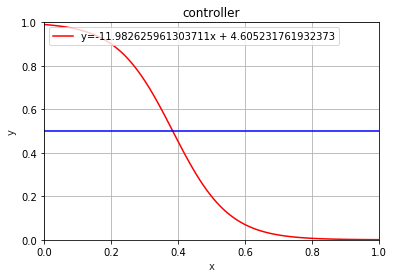

In [11]:
save_plot_controller()

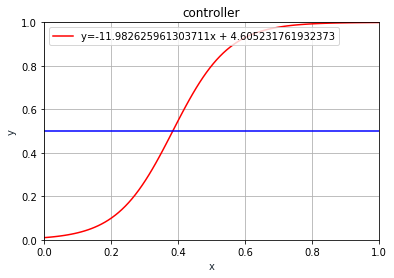

In [20]:
save_plot_controller()

In [ ]:
# Dataset
tracks = json.load(open('kitti_dataset.json'))
print('creating dataset...')
data_train = dataset_invariance.TrackDataset(tracks, len_past=past_len, len_future=future_len,
                                             train=True, dim_clip=dim_clip)
data_test = dataset_invariance.TrackDataset(tracks, len_past=past_len, len_future=future_len,
                                     train=False, dim_clip=dim_clip)
train_loader = DataLoader(data_train, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, num_workers=1, shuffle=False)
print('dataset created')

# loader iterator
dataiter_test = iter(train_loader)

In [ ]:
# iteration (test)
(index, past, future, presents, angle_presents, videos, vehicles, number_vec, scene, scene_one_hot) = dataiter_test.next()

In [ ]:
# Model Inference
# if ablation_study is None, the inference is default.
# if 'zeros', encoding of past is all zeros.
# if 'rand', encoding of past is random numbers (standard normal distribution, mean 0, variance 1).
# if 'different', encoding of all pasts (of batch) is the encoding of 'j_ablation' past.
ablation_study = 'different'
j_ablation = 802

with torch.no_grad():
    dim_batch = past.size()[0]
    zero_padding = torch.zeros(1, dim_batch, mem_n2n.dim_embedding_key * 2)
    prediction = torch.Tensor()
    present = past[:, -1, :2].unsqueeze(1)

    # temporal encoding for past
    past_t = torch.transpose(past, 1, 2)
    past_embed = mem_n2n.relu(mem_n2n.conv_past(past_t))
    past_embed = torch.transpose(past_embed, 1, 2)

    # temporal encoding for future
    future_t = torch.transpose(future, 1, 2)
    future_embed = mem_n2n.relu(mem_n2n.conv_fut(future_t))
    future_embed = torch.transpose(future_embed, 1, 2)

    # sequence encoding
    output_past, state_past = mem_n2n.encoder_past(past_embed)
    output_fut, state_fut = mem_n2n.encoder_fut(future_embed)

    if ablation_study is not None:
        if ablation_study is 'zeros':
            state_past = torch.zeros([1, dim_batch, 48])
        elif ablation_study is 'rand':
            state_past = torch.randn([1, dim_batch, 48])
        elif ablation_study is 'different':
            state_past = state_past[:,j].unsqueeze(0).repeat(1, dim_batch,1)

    # concatenate
    state_conc = torch.cat((state_past, state_fut), 2)
    input_fut = state_conc
    state_fut = zero_padding
    for i_pred in range(mem_n2n.future_len):
        output_decoder, state_fut = mem_n2n.decoder(input_fut, state_fut)
        displacement_next = mem_n2n.FC_output(output_decoder)
        coords_next = present + displacement_next.squeeze(0).unsqueeze(1)
        prediction = torch.cat((prediction, coords_next), 1)
        present = coords_next
        input_fut = zero_padding
prediction = prediction.numpy()

In [ ]:
draw_track(past[i], future[i], prediction[i], video_id=videos[i], vec_id=vehicles[i] + number_vec[i], index_tracklet=index[i].item() )

# PREDICTION FROM MEMORY

In [ ]:
with torch.no_grad():
    dim_batch = past.size()[0]
    zero_padding = torch.zeros(1, dim_batch * num_prediction, mem_n2n.dim_embedding_key * 2)
    prediction_mantra = torch.Tensor()
    present = past[:, -1].unsqueeze(1)

    # past temporal encoding
    past_t = torch.transpose(past, 1, 2)
    story_embed = mem_n2n.relu(mem_n2n.conv_past(past_t))
    story_embed = torch.transpose(story_embed, 1, 2)
    output_past, state_past = mem_n2n.encoder_past(story_embed)

    # Cosine similarity and memory read
    past_normalized = F.normalize(mem_n2n.memory_past, p=2, dim=1)
    state_normalized = F.normalize(state_past.squeeze(dim=0), p=2, dim=1)
    weight_read = torch.matmul(past_normalized, state_normalized.transpose(0, 1)).transpose(0, 1)
    index_max = torch.sort(weight_read, descending=True)[1].cpu()[:, :num_prediction]
    present = present.repeat_interleave(num_prediction, dim=0)
    state_past = state_past.repeat_interleave(num_prediction, dim=1)
    ind = index_max.flatten()


    info_future = mem_n2n.memory_fut[ind]
    info_total = torch.cat((state_past, info_future.unsqueeze(0)), 2)
    input_dec = info_total
    state_dec = zero_padding
    for i in range(future_len):
        output_decoder, state_dec = mem_n2n.decoder(input_dec, state_dec)
        displacement_next = mem_n2n.FC_output(output_decoder)
        coords_next = present + displacement_next.squeeze(0).unsqueeze(1)
        prediction_mantra = torch.cat((prediction_mantra, coords_next), 1)
        present = coords_next
        input_dec = zero_padding
    prediction_mantra = prediction_mantra.view(dim_batch, num_prediction, future_len, 2)



In [ ]:
prediction[0].shape

In [ ]:
draw_track_with_MANTRA(past[i], future[i], prediction_mantra[i], video_id=videos[i], vec_id=vehicles[i] + number_vec[i], index_tracklet=index[i].item() )